In [23]:
# Incorporate point-correlation
def correlation_fun(x,input_dim,Rad):
    point_corr=0
    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp1=tf.multiply(x[0][i,j],x[0][i,tf.mod(j+Rad,input_dim)])
            point_corr=tf.add(point_corr_temp1,point_corr)
    
    for i in range(input_dim):
        for j in range(input_dim):           
            point_corr_temp2=tf.multiply(x[0][i,j],x[0][tf.mod(i+Rad,input_dim),j])
            point_corr=tf.add(point_corr_temp2,point_corr)
    return (point_corr+2*input_dim**2)/4.

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

    return fig

def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="SAME"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)       
    
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu),stddev=1.0)
    return mu + tf.exp(log_var / 2) * eps

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
#     features_mean,features_var =tf.nn.moments(features,axes=[0])    
    features_mean = tf.reduce_mean(features,0)
    features = (features-features_mean)/1
    gram = backend.dot(features, backend.transpose(features))  
    return gram

def style_loss(style, combination):
    loss_temp=0.
    channels = 3
    size = height * width
    
    for i in range(mb_size):
        C = gram_matrix(combination[i])
        S = gram_matrix(style[i])
        loss_temp = tf.add(loss_temp,backend.sum(backend.square(S - C))/(4. * (channels ** 2) * (size ** 2)))*1e0
    
    return loss_temp

def claps_loss(x):
    z_d_gen=backend.batch_flatten(x)          
    nom = tf.matmul(z_d_gen, tf.transpose(z_d_gen, perm=[1, 0]))
    denom = tf.sqrt(tf.reduce_sum(tf.square(z_d_gen), reduction_indices=[1], keep_dims=True))
    pt = tf.square(tf.transpose((nom / denom), (1, 0)) / denom)
    pt = pt - tf.diag(tf.diag_part(pt))
    pulling_term = tf.reduce_sum(pt) / (mb_size * (mb_size - 1))*10
    
    return pulling_term

def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2_1 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/8, hight/8, 1]), 
                                                  deconv2_1_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/8, hight/8, deconv2_1_features]),deconv2_1_bias))

    h2_2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h2_1,deconv2_2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/4, hight/4, deconv2_2_features]),deconv2_2_bias))    
    
    h3_1 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h2_2, deconv3_1_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/4, hight/4, deconv3_1_features]),deconv3_1_bias))

    h3_2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h3_1, deconv3_2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, hight/2, deconv3_2_features]),deconv3_2_bias))
    
    h4_1 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h3_2, deconv4_1_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, hight/2, deconv4_1_features]),deconv4_1_bias))

    h4_2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h4_1, deconv4_2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, deconv4_2_features]),deconv4_2_bias))    
    
    h5 = (tf.add(tf.nn.conv2d_transpose(h4_2, deconv5_weight, strides=[1, 1, 1, 1], padding='SAME',
                                        output_shape=[mb_size, width/1, hight/1, 1]),deconv5_bias))
    
    prob = tf.nn.sigmoid(h5)
    return prob


def Q(X):
    h1_1 = tf.nn.relu(tf.add(conv2d(tf.reshape(X,[mb_size, width/1, height/1, 1]),
                                  conv1_1_weight, stride=1, padding='SAME'),conv1_1_bias))
    
    h1_2 = tf.nn.relu(tf.add(conv2d(h1_1,conv1_2_weight, stride=2, padding='SAME'),conv1_2_bias))
    
    h2_1 = tf.nn.relu(tf.add(conv2d(h1_2,conv2_1_weight, stride=1, padding='SAME'),conv2_1_bias))
    
    h2_2 = tf.nn.relu(tf.add(conv2d(h2_1,conv2_2_weight, stride=2, padding='SAME'),conv2_2_bias))

    h3_1 = tf.nn.relu(tf.add(conv2d(h2_2,conv3_1_weight, stride=1, padding='SAME'),conv3_1_bias))
    
    h3_2 = tf.nn.relu(tf.add(conv2d(h3_1,conv3_2_weight, stride=2, padding='SAME'),conv3_2_bias))    
    
    h4 = tf.nn.relu(tf.matmul(tf.reshape(h3_2,[mb_size,width/8*height/8*conv3_2_features]), Q_W1) + Q_b1)
    
    z_mu = tf.matmul(h4, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h4, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

In [24]:
######## loading input data ########
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
import h5py
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
# from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data


images = np.array(sio.loadmat('alloy_mat/sandstone_v2_test.mat')['Data'],dtype='float32')
images_L = np.array(sio.loadmat('alloy_mat/sandstone_v2_Young_test.mat')['L'],dtype='float32')
images=images[0:240]

mb_size = 20
X_dim = images.shape[1]
width = 128
height = 128
hight = 128
h_dim = width/8*height/8
z_dim = 128/8


conv1_1_features=32
conv1_2_features=32
conv2_1_features=32*2
conv2_2_features=32*2
conv3_1_features=32*3
conv3_2_features=32*3
conv4_features=1
c = 0

deconv2_1_features=32*3
deconv2_2_features=32*3
deconv3_1_features=32*2
deconv3_2_features=32*2
deconv4_1_features=32
deconv4_2_features=32
lr = 1e-3


# images_style = np.array(sio.loadmat('WB_raw2.mat')['WB'],dtype='float32')

style_array = np.zeros([len(images),height,width,3])
style_array[:,:,:,0]=(images.reshape(len(images),height,width))*1
style_array[:,:,:,1]=(images.reshape(len(images),height,width))*1
style_array[:,:,:,2]=(images.reshape(len(images),height,width))*1
print(style_array.shape)


(240, 128, 128, 3)


In [25]:
######## weights & bias loaading ########
f = h5py.File('weights_VGG/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','r')
ks = f.keys()

vgg16_weights=[]
vgg16_bias=[]
for i in range(18):
    if (len(f[ks[i]].values())) != 0:        
        vgg16_weights.append(f[ks[i]].values()[0][:])
        vgg16_bias.append(f[ks[i]].values()[1][:])
    else:
        continue

W_conv1 = (tf.constant(vgg16_weights[0]))
W_conv2 = (tf.constant(vgg16_weights[1]))
W_conv3 = (tf.constant(vgg16_weights[2]))
W_conv4 = (tf.constant(vgg16_weights[3]))
W_conv5 = (tf.constant(vgg16_weights[4]))
W_conv6 = (tf.constant(vgg16_weights[5]))
W_conv7 = (tf.constant(vgg16_weights[6]))
W_conv8 = (tf.constant(vgg16_weights[7]))
W_conv9 = (tf.constant(vgg16_weights[8]))
W_conv10= (tf.constant(vgg16_weights[9]))
W_conv11= (tf.constant(vgg16_weights[10]))
W_conv12= (tf.constant(vgg16_weights[11]))
W_conv13= (tf.constant(vgg16_weights[12]))

b_conv1 = tf.reshape(tf.constant(vgg16_bias[0]),[-1])
b_conv2 = tf.reshape(tf.constant(vgg16_bias[1]),[-1])
b_conv3 = tf.reshape(tf.constant(vgg16_bias[2]),[-1])
b_conv4 = tf.reshape(tf.constant(vgg16_bias[3]),[-1])
b_conv5 = tf.reshape(tf.constant(vgg16_bias[4]),[-1])
b_conv6 = tf.reshape(tf.constant(vgg16_bias[5]),[-1])
b_conv7 = tf.reshape(tf.constant(vgg16_bias[6]),[-1])
b_conv8 = tf.reshape(tf.constant(vgg16_bias[7]),[-1])
b_conv9 = tf.reshape(tf.constant(vgg16_bias[8]),[-1])
b_conv10 = tf.reshape(tf.constant(vgg16_bias[9]),[-1])
b_conv11 = tf.reshape(tf.constant(vgg16_bias[10]),[-1])
b_conv12 = tf.reshape(tf.constant(vgg16_bias[11]),[-1])
b_conv13 = tf.reshape(tf.constant(vgg16_bias[12]),[-1])

In [26]:
# =============================== Q(z|X) ======================================
z = tf.placeholder(tf.float32, shape=[None, z_dim])
x_input_shape = (mb_size, width, height, 1)
X = tf.placeholder(tf.float32, shape=x_input_shape)

conv1_1_weight = tf.Variable(tf.truncated_normal([4, 4, 1, conv1_1_features],
                                               stddev=0.1, dtype=tf.float32))
conv1_1_bias = tf.Variable(tf.zeros([conv1_1_features], dtype=tf.float32))

conv1_2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_1_features, conv1_2_features],
                                               stddev=0.1, dtype=tf.float32))
conv1_2_bias = tf.Variable(tf.zeros([conv1_2_features], dtype=tf.float32))

conv2_1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_2_features,conv2_1_features],
                                               stddev=0.1, dtype=tf.float32))
conv2_1_bias = tf.Variable(tf.zeros([conv2_1_features], dtype=tf.float32))

conv2_2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_1_features,conv2_2_features],
                                               stddev=0.1, dtype=tf.float32))

conv2_2_bias = tf.Variable(tf.zeros([conv2_2_features], dtype=tf.float32))

conv3_1_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_2_features,conv3_1_features],
                                               stddev=0.1, dtype=tf.float32))
conv3_1_bias = tf.Variable(tf.zeros([conv3_1_features], dtype=tf.float32))

conv3_2_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_1_features,conv3_2_features],
                                               stddev=0.1, dtype=tf.float32))

conv3_2_bias = tf.Variable(tf.zeros([conv3_2_features], dtype=tf.float32))



Q_W1 = tf.Variable(xavier_init([X_dim/8/8*conv3_2_features, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))

In [27]:
# =============================== P(X|z) ======================================
P_W1 = tf.Variable(xavier_init([z_dim, h_dim]),name="P_W1")
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]),name="P_b1")

deconv2_1_weight = tf.Variable(tf.truncated_normal([4, 4, deconv2_1_features, 1],
                                               stddev=0.1, dtype=tf.float32))
deconv2_1_bias = tf.Variable(tf.zeros([deconv2_1_features], dtype=tf.float32))

deconv2_2_weight = tf.Variable(tf.truncated_normal([4, 4, deconv2_2_features,deconv2_1_features],
                                               stddev=0.1, dtype=tf.float32))
deconv2_2_bias = tf.Variable(tf.zeros([deconv2_2_features], dtype=tf.float32))

deconv3_1_weight = tf.Variable(tf.truncated_normal([4, 4, deconv3_1_features, deconv2_2_features],
                                               stddev=0.1, dtype=tf.float32))
deconv3_1_bias = tf.Variable(tf.zeros([deconv3_1_features], dtype=tf.float32))

deconv3_2_weight = tf.Variable(tf.truncated_normal([4, 4, deconv3_2_features, deconv3_1_features],
                                               stddev=0.1, dtype=tf.float32))
deconv3_2_bias = tf.Variable(tf.zeros([deconv3_2_features], dtype=tf.float32))

deconv4_1_weight = tf.Variable(tf.truncated_normal([4, 4, deconv4_1_features, deconv3_2_features],
                                               stddev=0.1, dtype=tf.float32))
deconv4_1_bias = tf.Variable(tf.zeros([deconv4_1_features], dtype=tf.float32))

deconv4_2_weight = tf.Variable(tf.truncated_normal([4, 4, deconv4_2_features, deconv4_1_features],
                                               stddev=0.1, dtype=tf.float32))
deconv4_2_bias = tf.Variable(tf.zeros([deconv4_2_features], dtype=tf.float32))

deconv5_weight = tf.Variable(tf.truncated_normal([4, 4, 1, deconv4_2_features],
                                               stddev=0.1, dtype=tf.float32))
deconv5_bias = tf.Variable(tf.zeros([1], dtype=tf.float32))


In [28]:
# =============================== Middel Results ====================================
z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)



In [29]:
######## style transfer ########
combination_image_temp=tf.reshape(X_samples,[mb_size, height, width, 1])*1
combination_image = tf.concat([combination_image_temp, combination_image_temp,combination_image_temp], 3)

style_image = tf.placeholder(tf.float32, shape=(mb_size,height,width,3))

In [30]:
######### block 1 ########
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.relu(conv_out1)

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.bias_add(conv_out2, b_conv2)
conv_out2 = tf.nn.relu(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
conv_out3 = tf.nn.bias_add(conv_out3, b_conv3)
conv_out3 = tf.nn.relu(conv_out3)

conv_out4 = conv2d(conv_out3, W_conv4, stride=1, padding='SAME')
conv_out4 = tf.nn.bias_add(conv_out4, b_conv4)
conv_out4 = tf.nn.relu(conv_out4)
conv_out4 = max_pool(conv_out4, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5 = conv2d(conv_out4, W_conv5, stride=1, padding='SAME')
conv_out5 = tf.nn.bias_add(conv_out5, b_conv5)
conv_out5 = tf.nn.relu(conv_out5)

conv_out6 = conv2d(conv_out5, W_conv6, stride=1, padding='SAME')
conv_out6 = tf.nn.bias_add(conv_out6, b_conv6)
conv_out6 = tf.nn.relu(conv_out6)

conv_out7 = conv2d(conv_out6, W_conv7, stride=1, padding='SAME')
conv_out7 = tf.nn.bias_add(conv_out7, b_conv7)
conv_out7 = tf.nn.relu(conv_out7)
conv_out7 = max_pool(conv_out7, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8 = conv2d(conv_out7, W_conv8, stride=1, padding='SAME')
conv_out8 = tf.nn.bias_add(conv_out8, b_conv8)
conv_out8 = tf.nn.relu(conv_out8)

conv_out9 = conv2d(conv_out8, W_conv9, stride=1, padding='SAME')
conv_out9 = tf.nn.bias_add(conv_out9, b_conv9)
conv_out9 = tf.nn.relu(conv_out9)

conv_out10= conv2d(conv_out9, W_conv10, stride=1, padding='SAME')
conv_out10= tf.nn.bias_add(conv_out10, b_conv10)
conv_out10= tf.nn.relu(conv_out10)
conv_out10 = max_pool(conv_out10, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11= conv2d(conv_out10, W_conv11, stride=1, padding='SAME')
conv_out11= tf.nn.bias_add(conv_out11, b_conv11)
conv_out11= tf.nn.relu(conv_out11)

conv_out12= conv2d(conv_out11, W_conv12, stride=1, padding='SAME')
conv_out12= tf.nn.bias_add(conv_out12, b_conv12)
conv_out12= tf.nn.relu(conv_out12)

conv_out13= conv2d(conv_out12, W_conv13, stride=1, padding='SAME')
conv_out13= tf.nn.bias_add(conv_out13, b_conv12)
conv_out13= tf.nn.relu(conv_out13)

In [31]:
######### block 1 ########
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.bias_add(conv_out1_S, b_conv1)
conv_out1_S = tf.nn.relu(conv_out1_S)

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.bias_add(conv_out2_S, b_conv2)
conv_out2_S = tf.nn.relu(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
conv_out3_S = tf.nn.bias_add(conv_out3_S, b_conv3)
conv_out3_S = tf.nn.relu(conv_out3_S)

conv_out4_S = conv2d(conv_out3_S, W_conv4, stride=1, padding='SAME')
conv_out4_S = tf.nn.bias_add(conv_out4_S, b_conv4)
conv_out4_S = tf.nn.relu(conv_out4_S)
conv_out4_S = max_pool(conv_out4_S, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5_S = conv2d(conv_out4_S, W_conv5, stride=1, padding='SAME')
conv_out5_S = tf.nn.bias_add(conv_out5_S, b_conv5)
conv_out5_S = tf.nn.relu(conv_out5_S)

conv_out6_S = conv2d(conv_out5_S, W_conv6, stride=1, padding='SAME')
conv_out6_S = tf.nn.bias_add(conv_out6_S, b_conv6)
conv_out6_S = tf.nn.relu(conv_out6_S)

conv_out7_S = conv2d(conv_out6_S, W_conv7, stride=1, padding='SAME')
conv_out7_S = tf.nn.bias_add(conv_out7_S, b_conv7)
conv_out7_S = tf.nn.relu(conv_out7_S)
conv_out7_S = max_pool(conv_out7_S, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8_S = conv2d(conv_out7_S, W_conv8, stride=1, padding='SAME')
conv_out8_S = tf.nn.bias_add(conv_out8_S, b_conv8)
conv_out8_S = tf.nn.relu(conv_out8_S)

conv_out9_S = conv2d(conv_out8_S, W_conv9, stride=1, padding='SAME')
conv_out9_S = tf.nn.bias_add(conv_out9_S, b_conv9)
conv_out9_S = tf.nn.relu(conv_out9_S)

conv_out10_S= conv2d(conv_out9_S, W_conv10, stride=1, padding='SAME')
conv_out10_S= tf.nn.bias_add(conv_out10_S, b_conv10)
conv_out10_S= tf.nn.relu(conv_out10_S)
conv_out10_S= max_pool(conv_out10_S, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11_S= conv2d(conv_out10_S, W_conv11, stride=1, padding='SAME')
conv_out11_S= tf.nn.bias_add(conv_out11_S, b_conv11)
conv_out11_S= tf.nn.relu(conv_out11_S)

conv_out12_S= conv2d(conv_out11_S, W_conv12, stride=1, padding='SAME')
conv_out12_S= tf.nn.bias_add(conv_out12_S, b_conv12)
conv_out12_S= tf.nn.relu(conv_out12_S)

conv_out13_S= conv2d(conv_out12_S, W_conv13, stride=1, padding='SAME')
conv_out13_S= tf.nn.bias_add(conv_out13_S, b_conv13)
conv_out13_S= tf.nn.relu(conv_out13_S)

In [32]:
# =============================== latent to Young's Module ====================================
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with linear activation
    out_layer = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([z_dim, z_dim/4])),
    'h2': tf.Variable(tf.random_normal([z_dim/4, 1])),
}

biases = {
    'b1': tf.Variable(tf.random_normal([z_dim/4])),
    'b2': tf.Variable(tf.random_normal([1])),
}

label = tf.placeholder(tf.float32, shape=[None, 1])
pred = multilayer_perceptron(z_sample, weights, biases)

In [33]:
# =============================== Cost ====================================

# Style transfer
sl1 = style_loss(conv_out2_S,conv_out2)
sl2 = style_loss(conv_out4_S,conv_out4)
sl3 = style_loss(conv_out7_S,conv_out7)
sl4 = style_loss(conv_out10_S,conv_out10)
sl = sl1 + sl2 + sl3 + sl4

# Young's modulus cost
Young_cost = tf.reduce_mean(tf.square(pred - label))

# claps cost
cl1 = claps_loss(conv_out2)
cl2 = claps_loss(conv_out4)
cl3 = claps_loss(conv_out1)
cl4 = claps_loss(conv_out3)
cl = cl1+cl2+cl3+cl4

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/1
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss + cl + Young_cost + sl)



In [34]:
import random
solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
PC_ori=[]
saver = tf.train.Saver()
cl_E_store=[]
for it in range(100000):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    Y_L = images_L[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E,cl_E, sl_E,Young_E, sl_E1,sl_E2,sl_E3,sl_E4 = sess.run([solver, vae_loss, recon_loss, kl_loss,
                                                                             cl, sl, Young_cost, sl1, sl2, sl3, sl4],
                                                           feed_dict={X: X_mb.reshape(mb_size, width, height, 1),
                                                           label:Y_L.reshape(mb_size,1),
                                                           style_image: style_array_input.reshape(mb_size,128,128,3),
                                                           z: np.random.randn(mb_size, z_dim)})

    
    cl_E_store.append(cl_E)
    if it % 200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('Young_E:{}'.format(Young_E))
        print('cl_E:{}'.format(cl_E))
        print('sl_E:{}'.format(sl_E))
        print('sl_E1:{}'.format(sl_E1))
        print('sl_E2:{}'.format(sl_E2))
        print('sl_E3:{}'.format(sl_E3))
        print('sl_E4:{}'.format(sl_E4))
        
        print()


Iter: 0
Loss: 14414.4433594
recon_E:7738.80175781
kl_E:27.3754844666
Young_E:86.4276885986
cl_E:34.0724143982
sl_E:6527.76660156
sl_E1:875.111328125
sl_E2:2755.79736328
sl_E3:2896.78662109
sl_E4:0.0710953623056
()
Iter: 200
Loss: 2303.64794922
recon_E:1777.13549805
kl_E:30.9961872101
Young_E:1.27519750595
cl_E:33.2965927124
sl_E:460.944396973
sl_E1:53.4476852417
sl_E2:196.362808228
sl_E3:211.099090576
sl_E4:0.0348054729402
()
Iter: 400
Loss: 2026.56933594
recon_E:1570.29541016
kl_E:54.5014228821
Young_E:1.45868098736
cl_E:25.6029930115
sl_E:374.710754395
sl_E1:41.4280166626
sl_E2:144.846572876
sl_E3:188.409362793
sl_E4:0.0267940461636
()
Iter: 600
Loss: 1781.30761719
recon_E:1488.87023926
kl_E:46.2662200928
Young_E:0.56424331665
cl_E:25.7477588654
sl_E:219.859191895
sl_E1:26.4887180328
sl_E2:89.0661621094
sl_E3:104.285774231
sl_E4:0.0185455717146
()
Iter: 800
Loss: 1569.63464355
recon_E:1213.51416016
kl_E:51.0984802246
Young_E:0.871711671352
cl_E:23.6804771423
sl_E:280.469848633
sl_E1:

KeyboardInterrupt: 

In [13]:
plt.plot(cl_E_store)

In [90]:
save_path = saver.save(sess, "/tmp/model_hechao_deeper.ckpt")

In [20]:
save_path = saver.save(sess, "/tmp/model.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

for it in range(100000):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    Y_L = images_L[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E, Young_E, sl_E = sess.run([solver, vae_loss, recon_loss, kl_loss, Young_cost, sl], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
                                                              label:Y_L.reshape(mb_size,1),
                                                              style_image: style_array_input.reshape(mb_size,128,128,3),
                                                              z: np.random.randn(mb_size, z_dim)})

    if it % 200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('Young_E:{}'.format(Young_E))
        print('sl_E:{}'.format(sl_E))
        
        print()

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /tmp/model.ckpt
	 [[Node: save_2/RestoreV2_43 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_2/Const_0, save_2/RestoreV2_43/tensor_names, save_2/RestoreV2_43/shape_and_slices)]]
	 [[Node: save_2/RestoreV2_22/_27 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_86_save_2/RestoreV2_22", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'save_2/RestoreV2_43', defined at:
  File "/home/p2admin/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/p2admin/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-697ddf288a4c>", line 2, in <module>
    saver = tf.train.Saver()
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1040, in __init__
    self.build()
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1070, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/p2admin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /tmp/model.ckpt
	 [[Node: save_2/RestoreV2_43 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_2/Const_0, save_2/RestoreV2_43/tensor_names, save_2/RestoreV2_43/shape_and_slices)]]
	 [[Node: save_2/RestoreV2_22/_27 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_86_save_2/RestoreV2_22", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


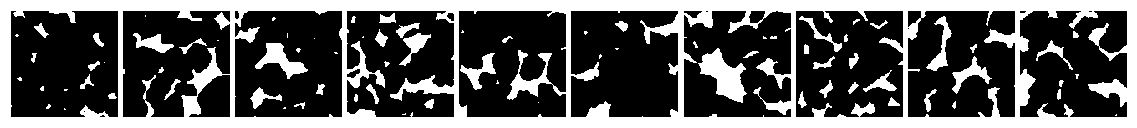

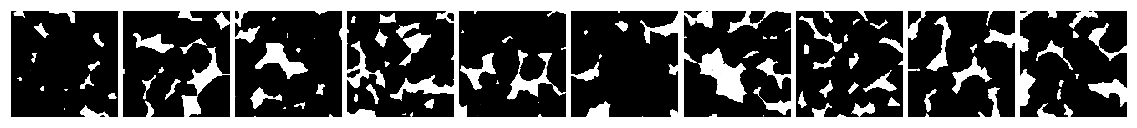

In [209]:
%matplotlib inline
def plot(samples):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(1, 10)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

X_mb = images[0:mb_size]
recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, 1),
                                 label:Y_L.reshape(mb_size,1)})
plot(images[10:20])
plot(recon[10:20])

In [210]:
sio.savemat('Hechao_Data/Reconstruction.mat',mdict={'recon':recon})

(array([  4.,   4.,  10.,  40.,  69.,  77.,  55.,  47.,  11.,   3.]),
 array([-2.249825  , -1.84527439, -1.44072378, -1.03617316, -0.63162255,
        -0.22707194,  0.17747867,  0.58202928,  0.9865799 ,  1.39113051,
         1.79568112]),
 <a list of 10 Patch objects>)

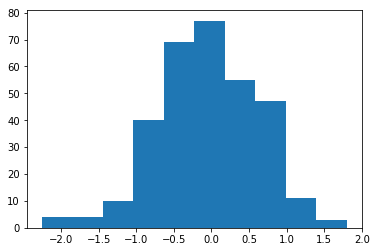

In [36]:
X_mb = images[0:20]
latent_z = sess.run(z_sample,feed_dict={X: X_mb.reshape(mb_size, width, height, 1)})
plt.hist(latent_z.reshape(-1))

(array([  6.,  18.,  32.,  42.,  55.,  51.,  53.,  39.,  20.,   4.]),
 array([-2.50089411, -2.00222631, -1.50355851, -1.00489071, -0.50622291,
        -0.00755511,  0.49111269,  0.98978049,  1.48844829,  1.98711609,
         2.48578389]),
 <a list of 10 Patch objects>)

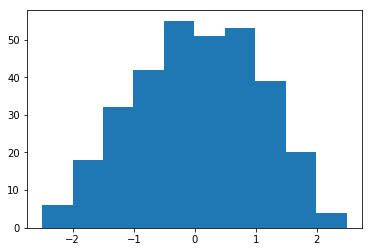

In [37]:
test=np.random.randn(mb_size, z_dim)
plt.hist(test.reshape(-1))

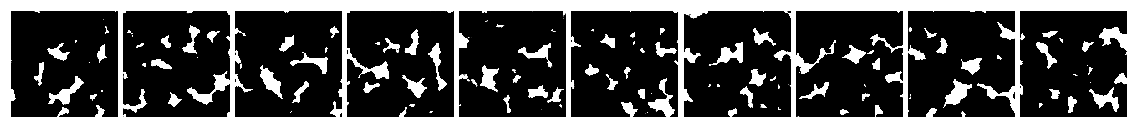

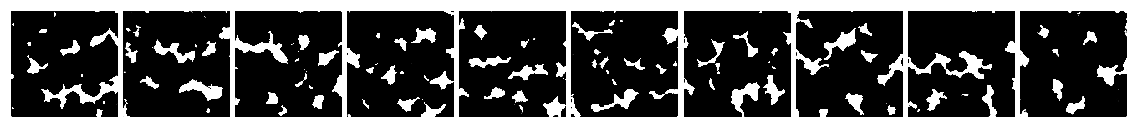

In [204]:
####### Random Generation
%matplotlib inline
samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)/1})
plot(samples[0:10])
plot(samples[10:20])

In [208]:
sio.savemat('Hechao_Data/Random_Generation.mat',mdict={'samples':samples})

0
20
20
40
40
60
60
80
80
100
100
120
120
140
140
160
160
180
180
200
200
220
220
240


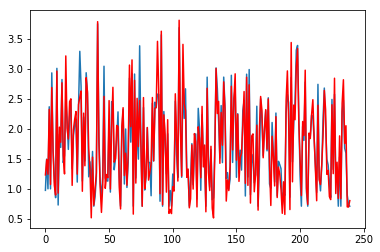

In [62]:
# =============================== Young's Modual Training Result ====================================
Y_pred_store_temp=[]
for it in range(240/mb_size):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    print((it*mb_size)%len(images))
    print((it*mb_size)%len(images)+mb_size)
    Y_pred = sess.run(pred, feed_dict={X: X_mb.reshape(mb_size, width, height, 1)})
    Y_pred_store_temp.append(Y_pred)
Y_pred_store=[]
for i in range(240/mb_size):
    for j in range(20):
        Y_pred_store.append(Y_pred_store_temp[i][j])
plt.plot(Y_pred_store)
plt.plot(images_L,'red')

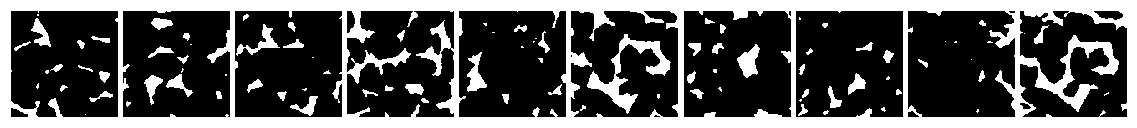

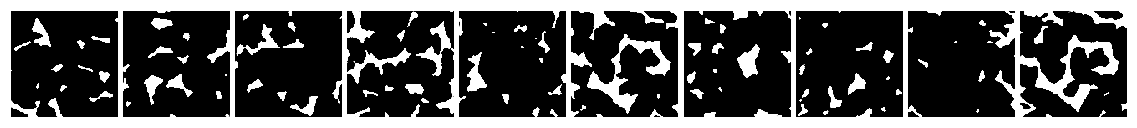

In [73]:
# =============================== Validation ====================================
images_test = np.array(sio.loadmat('alloy_mat/sandstone_v2_test.mat')['Data'],dtype='float32')
images_L_test = np.array(sio.loadmat('alloy_mat/sandstone_v2_Young_test.mat')['L'],dtype='float32')

X_mb_test=images_test[0:mb_size]
z_temp=sess.run(z_mu, feed_dict={X:X_mb_test.reshape(mb_size, width, height, 1)})
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
# plot_new(sample_temp)
plot(X_mb_test[0:10])
plot(sample_temp[0:10])

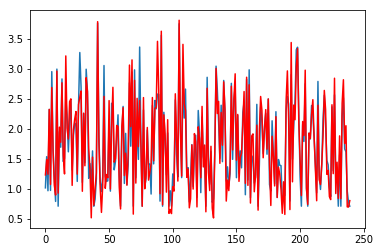

In [75]:
Y_pred_store_temp=[]
for it in range(240/mb_size):
    X_mb = images_test[(it*mb_size)%240:(it*mb_size)%240+mb_size]
    Y_pred = sess.run(pred, feed_dict={X: X_mb.reshape(mb_size, width, height, 1)})
    Y_pred_store_temp.append(Y_pred)
Y_pred_store=[]
for i in range(240/20):
    for j in range(20):
        Y_pred_store.append(Y_pred_store_temp[i][j])
plt.plot(Y_pred_store)
plt.plot(images_L_test,'red')   

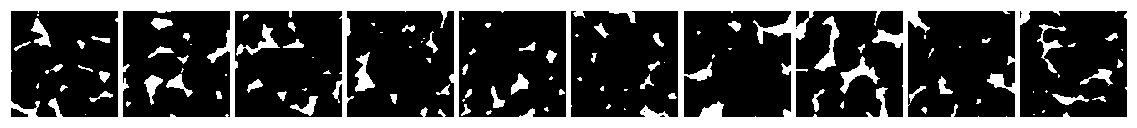

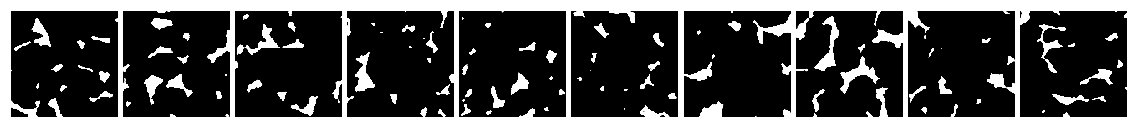

In [40]:
# =============================== Validation(Samples that can't predict well) ====================================
# =============================== Direct Reconstruct ====================================
images_diff = np.array(sio.loadmat('alloy_mat/diff_fig.mat')['img'],dtype='float32')


X_mb = images_diff[0:mb_size]
recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, 1)})
plot(images_diff[0:10])
plot(recon[0:10])


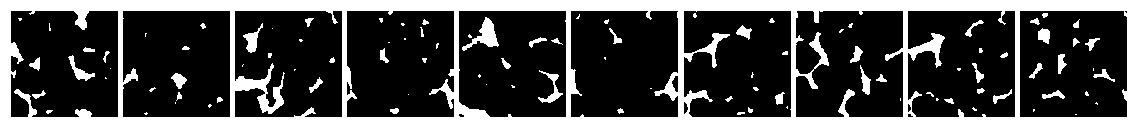

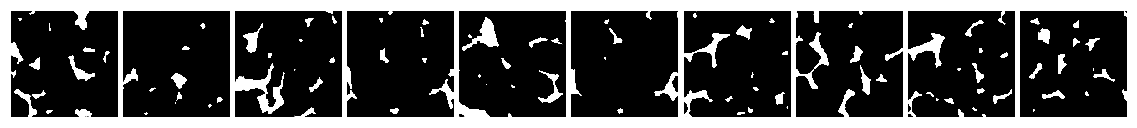

In [76]:
# =============================== Reconstruct by Latent Vector ====================================
X_mb = images_diff[0:mb_size]

z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, height, 1)})
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})

plot(X_mb[10:20])
plot(sample_temp[10:20])

In [104]:
images_index = np.array(sio.loadmat('alloy_mat/diff_fig.mat')['index'],dtype='int')
images_diff = np.array(sio.loadmat('alloy_mat/diff_fig.mat')['img'],dtype='float32')

mid_res=4 # number of generation between two samples

X_mb = images_diff[0:images_index[:,0:mb_size].reshape(-1),:,:,:]

IndexError: failed to coerce slice entry of type numpy.ndarray to integer

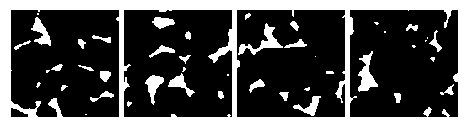

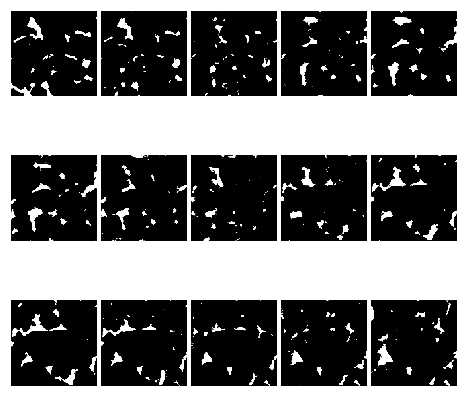

In [172]:
# =============================== Modification on Hard Samples ====================================
# 90 index, we pick the first 80 and leave the rest 10 for future validation
def plot_mid(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(3, 5)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')
    
def plot_ori(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(1, 4)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')


images_index = np.array(sio.loadmat('alloy_mat/diff_fig.mat')['index'],dtype='int')
images_diff = np.array(sio.loadmat('alloy_mat/diff_fig.mat')['img'],dtype='float32')

mid_res=5 # number of generation between two samples


z_store=[]

for ii in range(80/mb_size):
    X_mb = images_diff[ii*mb_size:(ii+1)*mb_size]
    xtr=np.zeros([mb_size*mid_res,width,height,1])
    for i in range(mb_size-1):  
        z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, height, 1)})
        for j in range(mid_res):
            step=(z_temp[i+1]-z_temp[i])/6.
            z_store_temp=z_temp[i]+step*(j+1)
            z_store.append(z_store_temp)

##### show example #####
z_store_test=np.array(z_store[0:mb_size])    
sample_generation=sess.run(X_samples, feed_dict={z: z_store_test})
plot_ori(images_diff[0:mb_size].reshape(mb_size, width, height, 1)[0:4])
plot_mid(sample_generation[0:15])
    

In [203]:
sample_store=[]
z_store=np.array(z_store) 
for i in range(len(z_store)/mb_size):  
    sample_generation=sess.run(X_samples, feed_dict={z: z_store[i*mb_size:(i+1)*mb_size,:]})
    sample_store.append(sample_generation)

sample_total=sample_store[0]
for i in range(1,len(sample_store)):
    sample_total=np.concatenate((sample_total, sample_store[i]), axis=0)
    
sio.savemat('Hechao_Data/Generation_test.mat',mdict={'sample_total':sample_total})

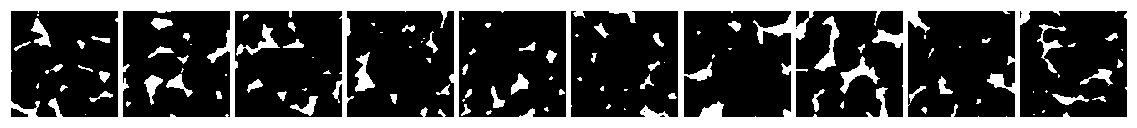

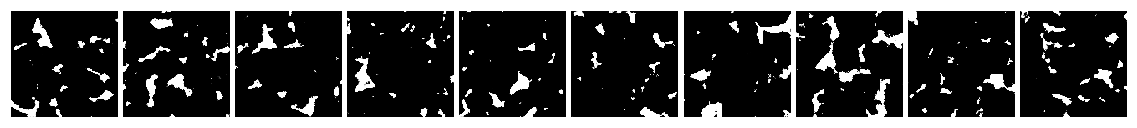

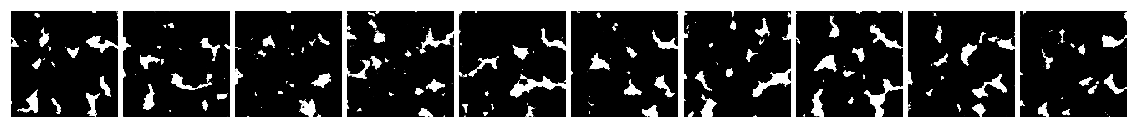

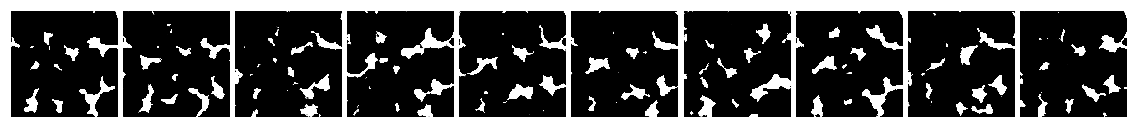

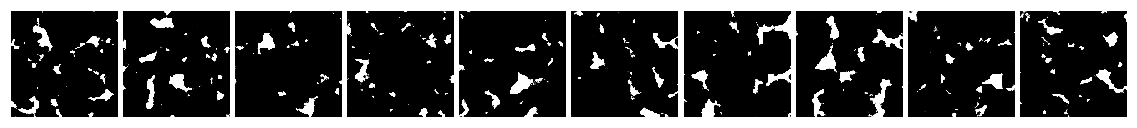

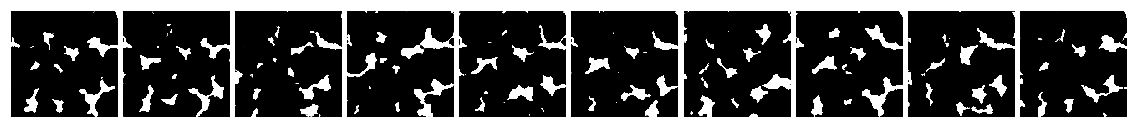

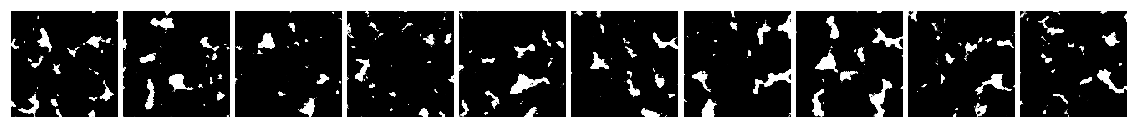

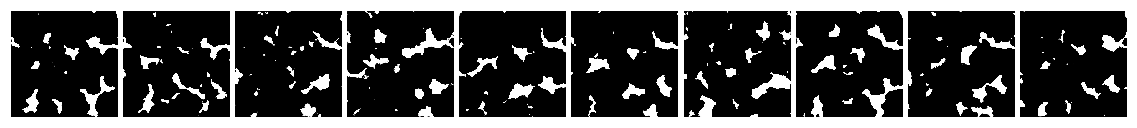

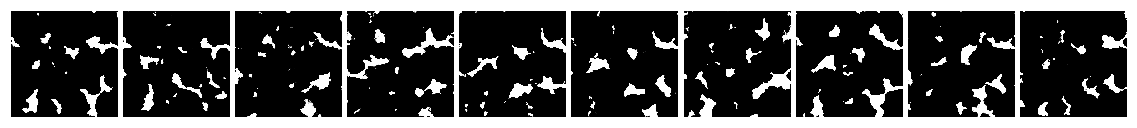

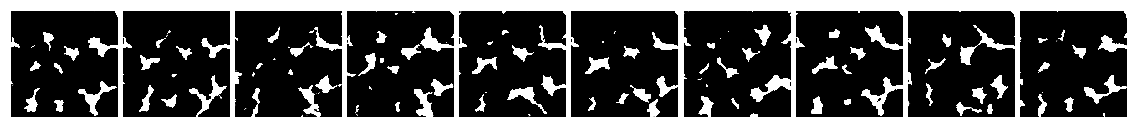

In [42]:
# =============================== Modification on Hard Samples ====================================
images_index = np.array(sio.loadmat('alloy_mat/diff_fig.mat')['index'],dtype='float32')
X_mb = images_diff[0:mb_size]
# recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
#                                  label:Y_L.reshape(mb_size,1)})

xtr=np.zeros([mb_size*10,width,height,1])
k=0
for i in range(10):  
    z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, height, 1)})
    for j in range(mid)
    
    rand_index=random.sample(np.arange(16),16)
    z_temp[:,rand_index]=z_temp[:,rand_index]+random.random()/1 
    
    sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
    xtr[k*mb_size:k*mb_size+mb_size,:,:,:]=sample_temp
    k=k+1
    
plot(X_mb[0:10])
plot(xtr[0:10])
plot(xtr[20:30])
plot(xtr[40:50])
plot(xtr[60:70])
plot(xtr[80:90])
plot(xtr[100:110])
plot(xtr[120:130])
plot(xtr[140:150])
plot(xtr[160:170])